In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error

%config IPCompleter.use_jedi = False

In [2]:
data_dir = 'data/'
train = pd.read_csv(data_dir + 'train.csv')
test = pd.read_csv(data_dir + 'test.csv')
from scipy.optimize import minimize

In [3]:
breath_ids = train["breath_id"].unique()

In [447]:
def eval_pid(x, temp):

    p0 = temp.iloc[0]["pressure"]

    p1 = temp[(temp["time_step"] > 0.85) & (temp["time_step"] < 0.98)].mean()[
        "pressure"
    ]

    p2 = temp["pressure"].iloc[-1]

    t_ref = 1.05

    kp = x[0] / 10
    ki = x[1] / 100
    kd = x[2] / 1000

    c = x[3] * 100

    err = p0 - p1
    int_ = 0
    de = (temp["pressure"].iloc[2]-temp["pressure"].iloc[0])
    
    arr = np.nan * np.ones((len(temp),3))
    
    arr[0] = [err, int_, de / temp["dt"].iloc[1]]

    error = [err]
    integral = [int_]
    derivative = [ de / temp["dt"].iloc[1]]
    
    for i in range(1, len(temp)):

        dt = temp["dt"].iloc[i]
        int_ = int_ + err * dt
        dif_ = de / dt

        de = kp * err + ki * int_ + kd * dif_ - err
        

        err = err + de

        arr[i] = [err, int_, de / dt]
        
    return arr

In [350]:
def pred_pressure(x, temp):

    p0 = temp.iloc[0]["pressure"]

    p1 = temp[(temp["time_step"] > 0.85) & (temp["time_step"] < 0.98)].mean()[
        "pressure"
    ]

    p2 = temp["pressure"].iloc[-1]

    t_ref = x[3]

    kp = x[0] / 10
    ki = x[1] / 100
    kd = x[2] / 1000

    #c = x[3] * 100

    err = p0 - p1
    int_ = 0
    de = (temp["pressure"].iloc[2]-temp["pressure"].iloc[0]) / temp["dt"].iloc[1]

    error = [err]
    
    #target = p1 - (p1 - p2) / (1 + np.exp(-c * (temp["time_step"] - t_ref)))
    
    target = np.where(
        temp["time_step"] < 1,
        p1,
        np.where(
            temp["time_step"] < t_ref,
            (p2-t_ref*p1+(p1-p2)*temp["time_step"]) / (1-t_ref),
            p2
        )
    )
    
    for i in range(1, len(temp)):

        dt = temp["dt"].iloc[i]
        int_ = int_ + err * dt
        dif_ = de / dt

        de = (kp * err + ki * int_ + kd * dif_ - err)

        err = err + de

        error.append(err)

    

    pred = target + error

    return pred


def sum_squad(x, temp):

    pred = pred_pressure(x, temp)

    return ((pred - temp["pressure"]) ** 2).sum()


# sns.lineplot(data = temp,x='time_step', y = 'pred')
# sns.lineplot(data = temp,x='time_step', y = 'pressure')

# plt.show()

In [351]:
# %%time

# temp = train.copy()[train["breath_id"]==32]

# p0 = temp.iloc[0]['pressure']

# p1 = temp[(temp["time_step"] > 0.85) & (temp["time_step"] < 0.98)].mean()['pressure']

# p2 = temp['pressure'].iloc[-1]

# t_ref = 1.05

# temp['dt'] = temp['time_step'].diff().fillna(0)

# # temp['output'] = temp['target'] + (kp*temp['proportional'] + ki*temp['integral'] + kd*temp['derivative'])

# # sns.lineplot(data = temp,x='time_step', y = 'target')
# sns.lineplot(data = temp,x='time_step', y = 'pressure')

# plt.show()

In [452]:
temp['R'].mean()

5.0

In [453]:
%%time
from tqdm import tqdm
list_ = []

for i in tqdm(range(10)):
    try:
        temp = train.copy()[train["breath_id"]==np.random.choice(breath_ids)]

        temp['dt'] = temp['time_step'].diff().fillna(0)

        x = minimize(
            sum_squad,
            (2,-2,-1, 1),
            args=(temp,),
            method='Nelder-Mead',
        )['x']

        list_.append(
            {
                'C':temp['C'].mean(),
                'R':temp['C'].mean(),
                'u_in_av':temp['u_in'].mean(),
                'u_out_av':temp['u_out'].mean(),
                'kp': x[0],
                'ki': x[1],
                'kd': x[2],
                't_ref': x[3],
            }
        )

    except:
        pass

100%|██████████| 10/10 [00:24<00:00,  2.41s/it]

CPU times: user 23.2 s, sys: 961 ms, total: 24.2 s
Wall time: 24.2 s


In [454]:
pd.DataFrame(list_)

,C,R,u_in_av,u_out_av,kp,ki,kd,t_ref
0,50.0,50.0,3.703518,0.6250,8.725122,-2.316113,-0.154938,1.168654
1,10.0,10.0,2.817292,0.6375,7.078873,3.046780,-12.283818,1.135614
2,50.0,50.0,10.138831,0.6375,8.873439,0.831554,0.283654,1.240530
3,50.0,50.0,22.149816,0.6375,9.186098,-2.280433,-0.356018,1.228016
4,50.0,50.0,5.636077,0.6000,5.296037,-0.702321,-2.714407,1.111746
5,20.0,20.0,6.296636,0.6125,9.396792,-0.303725,7.613781,1.078832
6,10.0,10.0,4.760291,0.6375,8.551723,-0.829016,-11.907970,1.105928
7,50.0,50.0,7.139929,0.6375,8.545844,-60.768209,-4.586326,1.068166
8,20.0,20.0,9.802594,0.6000,3.931728,-912.258507,-1.080961,1.117789
9,10.0,10.0,7.487380,0.6000,2.734048,-51.656624,-1.235244,1.108119


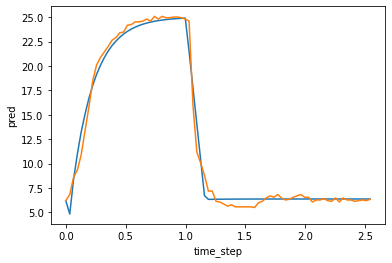

In [448]:
temp['pred'] = pred_pressure(x,temp)

sns.lineplot(data = temp,x='time_step', y = 'pred')
sns.lineplot(data = temp,x='time_step', y = 'pressure')

plt.show()

In [417]:
def pred_u_out(x,temp):
    
    pred_out = 1 + 1/(1+np.exp(-x[0]*(temp['u_in'] -x[1]) ))
    
    return pred_out

def sum_squad_u_out(x,temp):
    pred = pred_u_out(x,temp)
    true = temp['u_out']
    
    return ((pred-true)**2).sum()

<AxesSubplot:xlabel='u_in', ylabel='u_out'>

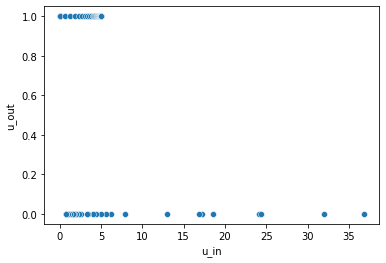

In [442]:
# x = minimize(
#     sum_squad_u_out,
#     (1, temp['u_in'].mean()),
#     args=(temp,),
#     method='Nelder-Mead',
# )['x']

# temp['u_out_pred'] = pred_u_out(x,temp)
sns.scatterplot(data = temp,x='u_in', y = 'u_out')
# sns.scatterplot(data = temp,x='u_in', y = 'u_out_pred')

In [445]:
temp['u_in'].mean()

4.744804878001672

In [446]:
temp['u_out'].mean()

0.6125

In [423]:
teste = train.groupby(['breath_id']).agg(
    R = ('R','mean'),
    C = ('C','mean'),
    u_in_av = ('u_in','mean')
)

<AxesSubplot:xlabel='u_in_av', ylabel='C'>

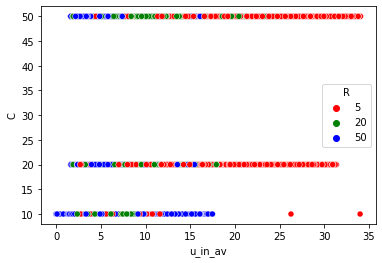

In [430]:
sns.scatterplot(data = teste,x='u_in_av', y = 'C',hue='R',palette=['red','green','blue'])

In [425]:
teste.corr()

,R,C,u_in_av
R,1.000000,-0.09607,-0.361829
C,-0.096070,1.00000,0.368870
u_in_av,-0.361829,0.36887,1.000000


In [439]:
mean_absolute_error(temp['pressure'],pred_pressure(x,temp))

0.5387955816178011

In [311]:
from statsmodels.tsa.seasonal import seasonal_decompose

## 0. Introduction
- Updated 10/04/2021
- This code is a baseline with LighGBM train method.
- Shown to confirm overfitting
- Shown Importance feature by lightGBM feature_importance function
- Finished to submit

### 0-1. Libarary

In [1]:
import os
import gc
import glob
import time
import random
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler

### 0-2. Debug

In [3]:
# For debug
class Debug:
    def __init__(self):
        self._debug = 0
        self.debug_size = 100
        self.data_dir = 'data/'
        
debug = Debug()

## 1 EDA & Preprocessing
### 1-1. Train & Test data

In [4]:
# Read train and test CSV data
def read_train_test():
    train = pd.read_csv(debug.data_dir + 'train.csv')
    test = pd.read_csv(debug.data_dir + 'test.csv')
    return train, test

train, test = read_train_test()

# Select random breath_id for degug
if debug._debug:
    random.seed(2021)
    lst_train = random.sample(set(train['breath_id'].unique()), debug.debug_size)
    lst_test = random.sample(set(test['breath_id'].unique()), debug.debug_size)
    train_tmp = pd.DataFrame()
    test_tmp = pd.DataFrame()
    for i in lst_train:
        train_tmp = pd.concat([train_tmp, train[train['breath_id'] == i]], axis=0)
    for i in lst_test:
        test_tmp = pd.concat([test_tmp, test[test['breath_id'] == i]], axis=0)
    train, test = train_tmp, test_tmp
    
train.head(2)

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794


### 1-2. Exploratory Data Analysis
### Feature
- id - globally-unique time step identifier across an entire file
- breath_id - globally-unique time step for breaths
- R - lung attribute indicating how restricted the airway is (in cmH2O/L/S). Physically, this is the change in pressure per change in flow (air volume per time). Intuitively, one can imagine blowing up a balloon through a straw. We can change R by changing the diameter of the straw, with higher R being harder to blow.
- C - lung attribute indicating how compliant the lung is (in mL/cmH2O). Physically, this is the change in volume per change in pressure. Intuitively, one can imagine the same balloon example. We can change C by changing the thickness of the balloon’s latex, with higher C having thinner latex and easier to blow.
- time_step - the actual time stamp.
- u_in - the control input for the inspiratory solenoid valve. Ranges from 0 to 100.
- u_out - the control input for the exploratory solenoid valve. Either 0 or 1.
- pressure - the airway pressure measured in the respiratory circuit, measured in cmH2O.

In [5]:
## Describe in exclude id columns
train[train.columns[1:]].describe(include='all').round(3)

,breath_id,R,C,time_step,u_in,u_out,pressure
count,6036000.000,6036000.000,6036000.000,6036000.000,6036000.000,6036000.000,6036000.000
mean,62838.859,27.036,26.081,1.307,7.322,0.620,11.220
std,36335.256,19.595,17.152,0.766,13.435,0.485,8.110
min,1.000,5.000,10.000,0.000,0.000,0.000,-1.896
25%,31377.000,5.000,10.000,0.643,0.394,0.000,6.330
50%,62765.500,20.000,20.000,1.308,4.386,1.000,7.033
75%,94301.000,50.000,50.000,1.966,4.984,1.000,13.641
max,125749.000,50.000,50.000,2.937,100.000,1.000,64.821


### 1-3. Time series data(pressure/ u_in / u_out)
- from [https://www.kaggle.com/kaitohonda/beginner-lgbm](https://www.kaggle.com/kaitohonda/beginner-lgbm)

In [6]:
if debug._debug:
    fig, ax = plt.subplots(1, 3, figsize=(30, 6))
    sns.set(font_scale=1.2)
    for i, num in enumerate(random.sample(lst_train, 3)):
        df = train[train['breath_id']==num]
        ax2 = ax[i].twinx()

        sns.lineplot(data=df, x='time_step', y='pressure', label='pressure', ax=ax[i])
        sns.lineplot(data=df, x='time_step', y='u_in', label='u_in', ax=ax[i])
        sns.lineplot(data=df, x='time_step', y='u_out', label='u_out', ax=ax2, color='r')

        ax[i].set(xlabel='Timestep', ylabel='pressure, u_in', title=f'breath_id: {num}', xlim=(-0.2, 3.2), ylim=(-5, 105))
        ax[i].legend(loc=(0.75, 0.7))
        ax2.legend(loc=(0.75, 0.6))
    plt.show()

### 1-4. Preprocessing

In [7]:
def log_exp_return(series):
    return np.exp(np.log1p(series).diff(1).fillna(0))

def preprocessing(df):
    # time diff
    df['time_diff'] = df['time_step'].groupby(df['breath_id']).diff(1).fillna(0)
    
    # u_in parameter
    df['u_in_ratio'] = df['u_in'].groupby(df['breath_id']).apply(log_exp_return)
    df['last_value_u_in'] = df['u_in'].groupby(df['breath_id']).transform('last')
    df['first_value_u_in'] = df['u_in'].groupby(df['breath_id']).transform('first')

    # u_in area
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum() 
    
    # u_in shift change 
    for i in np.arange(1, 3, 1):
        df[f'u_in_lag_fwrd{i}'] = df['u_in'].groupby(df['breath_id']).shift(i).fillna(0)
        df[f'u_in_lag_back{i}'] = df['u_in'].groupby(df['breath_id']).shift(int(-i)).fillna(0)
       
    # R, C parameter
    df['RC'] = df['C'] * df['R']
    df['R/C'] = df['R'] / df['C']
    df['C/R'] = df['C'] / df['R']
    df['R'] = df['R'].astype('category')
    df['C'] = df['C'].astype('category')
    df['RC'] = df['RC'].astype('category')
    df['R/C'] = df['R/C'].astype('category')
    df['C/R'] = df['C/R'].astype('category')
    
    return df

train = preprocessing(train)
test = preprocessing(test)

# Create each data for lightgbm
target = train["pressure"].values
train = train.drop(["id", 'breath_id', "pressure"], axis=1)
test = test.drop(["id", 'breath_id'], axis=1)
feature_column = train.columns.values

### 1-5. RobustScaler

In [8]:
rs = RobustScaler()
train = rs.fit_transform(train)
test = rs.transform(test)
train.shape, test.shape

((6036000, 18), (4024000, 18))

## 2. LightGBM
### 2-1. LightGBM class
- Create Class
- You can change easier any parameters

In [ ]:
class LGBM:
    def __init__(self, feature_column):
        self.num_boost_round = 8000
        self.verbose_eval = 1000
        self.early_stopping_rounds = 100
        self.cv = 5
        self.kf = KFold(n_splits=self.cv, shuffle=True, random_state=2021)
        self.n_splits = self.cv
        self.boosters = []
        self.scores = []
        self.eval_results_lst = []
        self.feature_column = feature_column
        self.feature_importance = pd.DataFrame()
        
    def lgbm_train(self, train, target):
        params = {
                'objective': 'regression_l1',
                'metric': 'mae',
                'boosting_type': 'gbdt',
                'verbose': -1
                }
        
        # Lughgbm train
        for fold, (trn_idx, val_idx) in enumerate(self.kf.split(train, target)):
            eval_results = {}
            print("="*15 + f' Fold {fold+1} started at {time.ctime()} ' + "="*15)
            X_trn, X_val = train[trn_idx], train[val_idx]
            y_trn, y_val = target[trn_idx], target[val_idx]
            lgb_trn = lgb.Dataset(X_trn, label=y_trn)
            lgb_val = lgb.Dataset(X_val, label=y_val)
            booster = lgb.train(params=params, 
                                train_set=lgb_trn, 
                                valid_sets=[lgb_trn, lgb_val],
                                valid_names=['Train', 'Valid'], 
                                num_boost_round=self.num_boost_round, 
                                early_stopping_rounds=self.early_stopping_rounds, 
                                verbose_eval=self.verbose_eval,
                                evals_result=eval_results)   
            
            y_pred = booster.predict(X_val, num_iteration=booster.best_iteration)
            score = mae(y_val, y_pred)
            print(f'MAE: {score}')
            
            self.eval_results_lst.append(eval_results)
            self.boosters.append(booster)
            self.scores.append(score)            
            
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = self.feature_column
            fold_importance["importance"] = booster.feature_importance()
            fold_importance["fold"] = fold + 1
            self.feature_importance = pd.concat([self.feature_importance, fold_importance], axis=0)
        
            del X_trn, X_val, y_trn, y_val, lgb_trn, lgb_val, fold_importance
            gc.collect()
                
    # Vizualize Importance columns
    def importance_show(self, top=20):
        df_tmp = self.feature_importance
        sns.set(font_scale=1.2)
        fig, ax = plt.subplots(1, self.cv, figsize=(30, 20))
        for i in range(self.cv):
            df = df_tmp[df_tmp["fold"]==i+1].sort_values('importance', ascending=False)
            sns.barplot(data=df[:top], x="importance", y="feature", ci=None, ax=ax[i])
            ax[i].set_title(f"Fold: {i+1}")
        plt.tight_layout()
        plt.show()
        
        del df_tmp
        gc.collect()

### 2-3. LightGBM Train

In [ ]:
lgbm_inst = LGBM(feature_column)
lgbm_inst.lgbm_train(train, target)

### 2-4. Checking overfitting
- Checking overfitting using eval_results dict

In [ ]:
fig, ax = plt.subplots(1, lgbm_inst.cv, figsize=(30, 6))
for i, results in enumerate(lgbm_inst.eval_results_lst):
    ax[i].plot(np.log(results['Train']['l1']), label='train')
    ax[i].plot(np.log(results['Valid']['l1']), label='valid')
    ax[i].set(xlabel="Boosting round", ylabel = 'Log_loss', title = f'Training Fold {i+1}')
plt.legend()
plt.show()

### 2-5. Feature Importance
- Visualize how each explanatory variable affects the objective function

In [ ]:
print('\n CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(lgbm_inst.scores), np.std(lgbm_inst.scores)))
lgbm_inst.importance_show(top=20)

## 3.Submission

In [ ]:
if not debug._debug:
    submission = pd.read_csv(debug.data_dir + "sample_submission.csv")
    for booster in lgbm_inst.boosters:
        submission['pressure'] += booster.predict(test, num_iteration=booster.best_iteration)
    submission['pressure'] /= lgbm_inst.cv
    submission.to_csv('submission_lgb.csv', index=False)
    print(submission.tail(2))